In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

We've talked about Random Forests. Now it's time to build one.

Here we'll use data Lending Club to predict the state of a loan given some information about it. You can find the dataset here. We'll use 2015 data.

In [2]:
# Replace the path with the correct path for your data
y2015 = pd.read_csv('LoanStats3d.csv', 
                    skipinitialspace=True,
                   header=1
)

# Note the warning about dtypes.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.000,16000.000,16000.000,16000.000,60 months,14.85%,379.390,C,C5,...,0.000,2.000,78.900,0.000,0.000,2.000,298100.000,31329.000,281300.000,13400.000
1,68354783,73244544.000,9600.000,9600.000,9600.000,36 months,7.49%,298.580,A,A4,...,0.000,2.000,100.000,66.700,0.000,0.000,88635.000,55387.000,12500.000,75635.000
2,68466916,73356753.000,25000.000,25000.000,25000.000,36 months,7.49%,777.550,A,A4,...,0.000,0.000,100.000,20.000,0.000,0.000,373572.000,68056.000,38400.000,82117.000
3,68466961,73356799.000,28000.000,28000.000,28000.000,36 months,6.49%,858.050,A,A2,...,0.000,0.000,91.700,22.200,0.000,0.000,304003.000,74920.000,41500.000,42503.000
4,68495092,73384866.000,8650.000,8650.000,8650.000,36 months,19.89%,320.990,E,E3,...,0.000,12.000,100.000,50.000,1.000,0.000,38998.000,18926.000,2750.000,18248.000


## The Blind Approach

Now, as we've seen before, creating a model is the easy part. Let's try just using everything we've got and throwing it without much thought into a Random Forest. SKLearn requires the independent variables to be be numeric, and all we want is dummy variables so let's use `get_dummies` from Pandas to generate a dummy variable for every categorical colummn and see what happens off of this kind of naive approach.

In [4]:
y2015['loan_status']

0                    Current
1                    Current
2                 Fully Paid
3                    Current
4                 Fully Paid
5                    Current
6                    Current
7                 Fully Paid
8                    Current
9                 Fully Paid
10                   Current
11                   Current
12                   Current
13                   Current
14                Fully Paid
15                   Current
16                   Current
17                   Current
18                   Current
19                   Current
20                   Current
21                Fully Paid
22                   Current
23                   Current
24                   Current
25                   Current
26                   Current
27                Fully Paid
28                   Current
29                   Current
                 ...        
421067               Current
421068           Charged Off
421069            Fully Paid
421070        

### The Blind Approach

Now, as we've seen before, creating a model is the easy part. Let's try just using everything we've got and throwing it without much though into a Random Forest. SKLearn requires the independent variables to be numeric, and all we want is dummy variables so let's use **get_dummies** from Pandas to generate a dummy variable for every categorical column and see what happpens off of this kind of naive approach.

In [5]:
# from sklearn import ensemble
# from sklearn.model_selection import cross_val_score

# rfc = ensemble.RandomForestClassifier()
# X = y2015.drop('loan_status', 1)
# Y = y2015['loan_status']
# X = pd.get_dummies(X)

# cross_val_score(rfc, X, Y, cv=5)

Did your kernel die? My kernel died.

Guess it isn't going to be that easy...

Can you think of what went wrong?

(You're going to have to reset your kernel and reload the column, BUT DON'T RUN THE MODEL AGAIN OR YOU'LL CRASH THE KERNEL AGAIN!))

### Data Cleaning

Well, get_dummies can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [6]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [7]:
# Convert ID and Interest Rate to numeric
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which $should$ have all been integers? Let's look at the end of the file.

In [8]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.000,38982739.000,13000.000,13000.000,13000.000,60 months,15.990,316.070,D,5 years,...,0.000,3.000,100.000,50.000,1.000,0.000,51239.000,34178.000,10600.000,33239.000
421093,36490806.000,39222577.000,12000.000,12000.000,12000.000,60 months,19.990,317.860,E,1 year,...,1.000,2.000,95.000,66.700,0.000,0.000,96919.000,58418.000,9700.000,69919.000
421094,36271262.000,38982659.000,20000.000,20000.000,20000.000,36 months,11.990,664.200,B,10+ years,...,0.000,1.000,100.000,50.000,0.000,1.000,43740.000,33307.000,41700.000,0.000
421095,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,NaN,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
421096,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,NaN,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [9]:
y2015 = y2015[:-2]

Now this should be better. Let's try again.

In [10]:
pd.get_dummies(y2015)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_INDIVIDUAL,application_type_JOINT,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,68009401.000,72868139.000,16000.000,16000.000,16000.000,14.850,379.390,48000.000,33.180,0.000,...,0,0,0,0,0,1,0,0,0,0
1,68354783.000,73244544.000,9600.000,9600.000,9600.000,7.490,298.580,60000.000,22.440,0.000,...,0,0,0,0,0,1,0,0,0,0
2,68466916.000,73356753.000,25000.000,25000.000,25000.000,7.490,777.550,109000.000,26.020,0.000,...,0,0,0,0,0,1,0,0,0,0
3,68466961.000,73356799.000,28000.000,28000.000,28000.000,6.490,858.050,92000.000,21.600,0.000,...,0,0,0,0,0,1,0,0,0,0
4,68495092.000,73384866.000,8650.000,8650.000,8650.000,19.890,320.990,55000.000,25.490,0.000,...,0,0,0,0,0,1,0,0,0,0
5,68506798.000,73396623.000,23000.000,23000.000,23000.000,8.490,471.770,64000.000,18.280,0.000,...,0,0,0,0,0,1,0,0,0,0
6,68566886.000,73456723.000,29900.000,29900.000,29900.000,12.880,678.490,65000.000,21.770,0.000,...,0,0,0,0,0,1,0,0,0,0
7,68577849.000,73467703.000,18000.000,18000.000,18000.000,11.990,400.310,112000.000,8.680,0.000,...,0,0,0,0,0,1,0,0,0,0
8,66310712.000,71035433.000,35000.000,35000.000,35000.000,14.850,829.900,110000.000,17.060,0.000,...,0,0,0,0,0,1,0,0,0,0
9,68476807.000,73366655.000,10400.000,10400.000,10400.000,22.450,289.910,104433.000,25.370,1.000,...,0,0,0,0,0,1,0,0,0,0


It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [11]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.97917409, 0.98036143, 0.98143003, 0.98154876, 0.96390406,
       0.97409166, 0.9414377 , 0.98069296, 0.97995583, 0.9800741 ])

The scores that cross validation reports are the accuracy scores of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that on gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

### DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation. 

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [12]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401.000,72868139.000,16000.000,16000.000,16000.000,60 months,14.850,379.390,C,10+ years,...,0.000,2.000,78.900,0.000,0.000,2.000,298100.000,31329.000,281300.000,13400.000
1,68354783.000,73244544.000,9600.000,9600.000,9600.000,36 months,7.490,298.580,A,8 years,...,0.000,2.000,100.000,66.700,0.000,0.000,88635.000,55387.000,12500.000,75635.000
2,68466916.000,73356753.000,25000.000,25000.000,25000.000,36 months,7.490,777.550,A,10+ years,...,0.000,0.000,100.000,20.000,0.000,0.000,373572.000,68056.000,38400.000,82117.000
3,68466961.000,73356799.000,28000.000,28000.000,28000.000,36 months,6.490,858.050,A,10+ years,...,0.000,0.000,91.700,22.200,0.000,0.000,304003.000,74920.000,41500.000,42503.000
4,68495092.000,73384866.000,8650.000,8650.000,8650.000,36 months,19.890,320.990,E,8 years,...,0.000,12.000,100.000,50.000,1.000,0.000,38998.000,18926.000,2750.000,18248.000


In [13]:
y2015['loan_status'].unique()

array(['Current', 'Fully Paid', 'Charged Off', 'Late (31-120 days)',
       'In Grace Period', 'Default', 'Late (16-30 days)'], dtype=object)

In [14]:
# Recode loan_status to accomodate statistical analysis
loan_stat_dict = {'Fully Paid':0,
                  'Current': 1,
                  'Charged Off': 2,
                  'Late (31-120 days)': 3,
                  'In Grace Period': 4,
                  'Default': 5, 
                  'Late (16-30 days)': 6}
y2015['loan_status'] = y2015['loan_status'].apply(lambda x: loan_stat_dict[x])

In [15]:
y2015['loan_status']

0         1
1         1
2         0
3         1
4         0
5         1
6         1
7         0
8         1
9         0
10        1
11        1
12        1
13        1
14        0
15        1
16        1
17        1
18        1
19        1
20        1
21        0
22        1
23        1
24        1
25        1
26        1
27        0
28        1
29        1
         ..
421065    1
421066    1
421067    1
421068    2
421069    0
421070    1
421071    0
421072    1
421073    1
421074    3
421075    1
421076    0
421077    1
421078    1
421079    0
421080    1
421081    0
421082    0
421083    0
421084    1
421085    0
421086    1
421087    2
421088    0
421089    2
421090    1
421091    1
421092    2
421093    2
421094    1
Name: loan_status, Length: 421095, dtype: int64

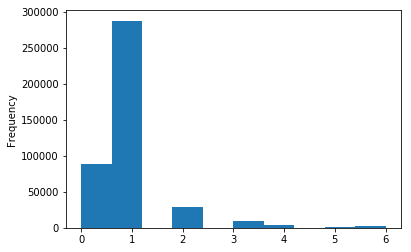

In [16]:
# Plotting histogram of outcome variable
y2015.loan_status.plot(kind='hist')

In [17]:
y2015.shape

(421095, 103)

loan_status                  1.000
out_prncp                    0.261
out_prncp_inv                0.261
collection_recovery_fee      0.169
recoveries                   0.168
int_rate                     0.133
total_rec_int                0.127
total_rec_late_fee           0.118
bc_util                      0.078
percent_bc_gt_75             0.074
all_util                     0.068
num_rev_tl_bal_gt_0          0.052
num_actv_rev_tl              0.050
id                           0.041
member_id                    0.041
loan_amnt                    0.034
funded_amnt                  0.034
funded_amnt_inv              0.034
dti                          0.032
num_actv_bc_tl               0.032
dti_joint                    0.031
inq_last_6mths               0.029
installment                  0.028
acc_open_past_24mths         0.025
inq_fi                       0.022
delinq_2yrs                  0.021
open_il_24m                  0.019
open_il_6m                   0.019
num_tl_op_past_12m  

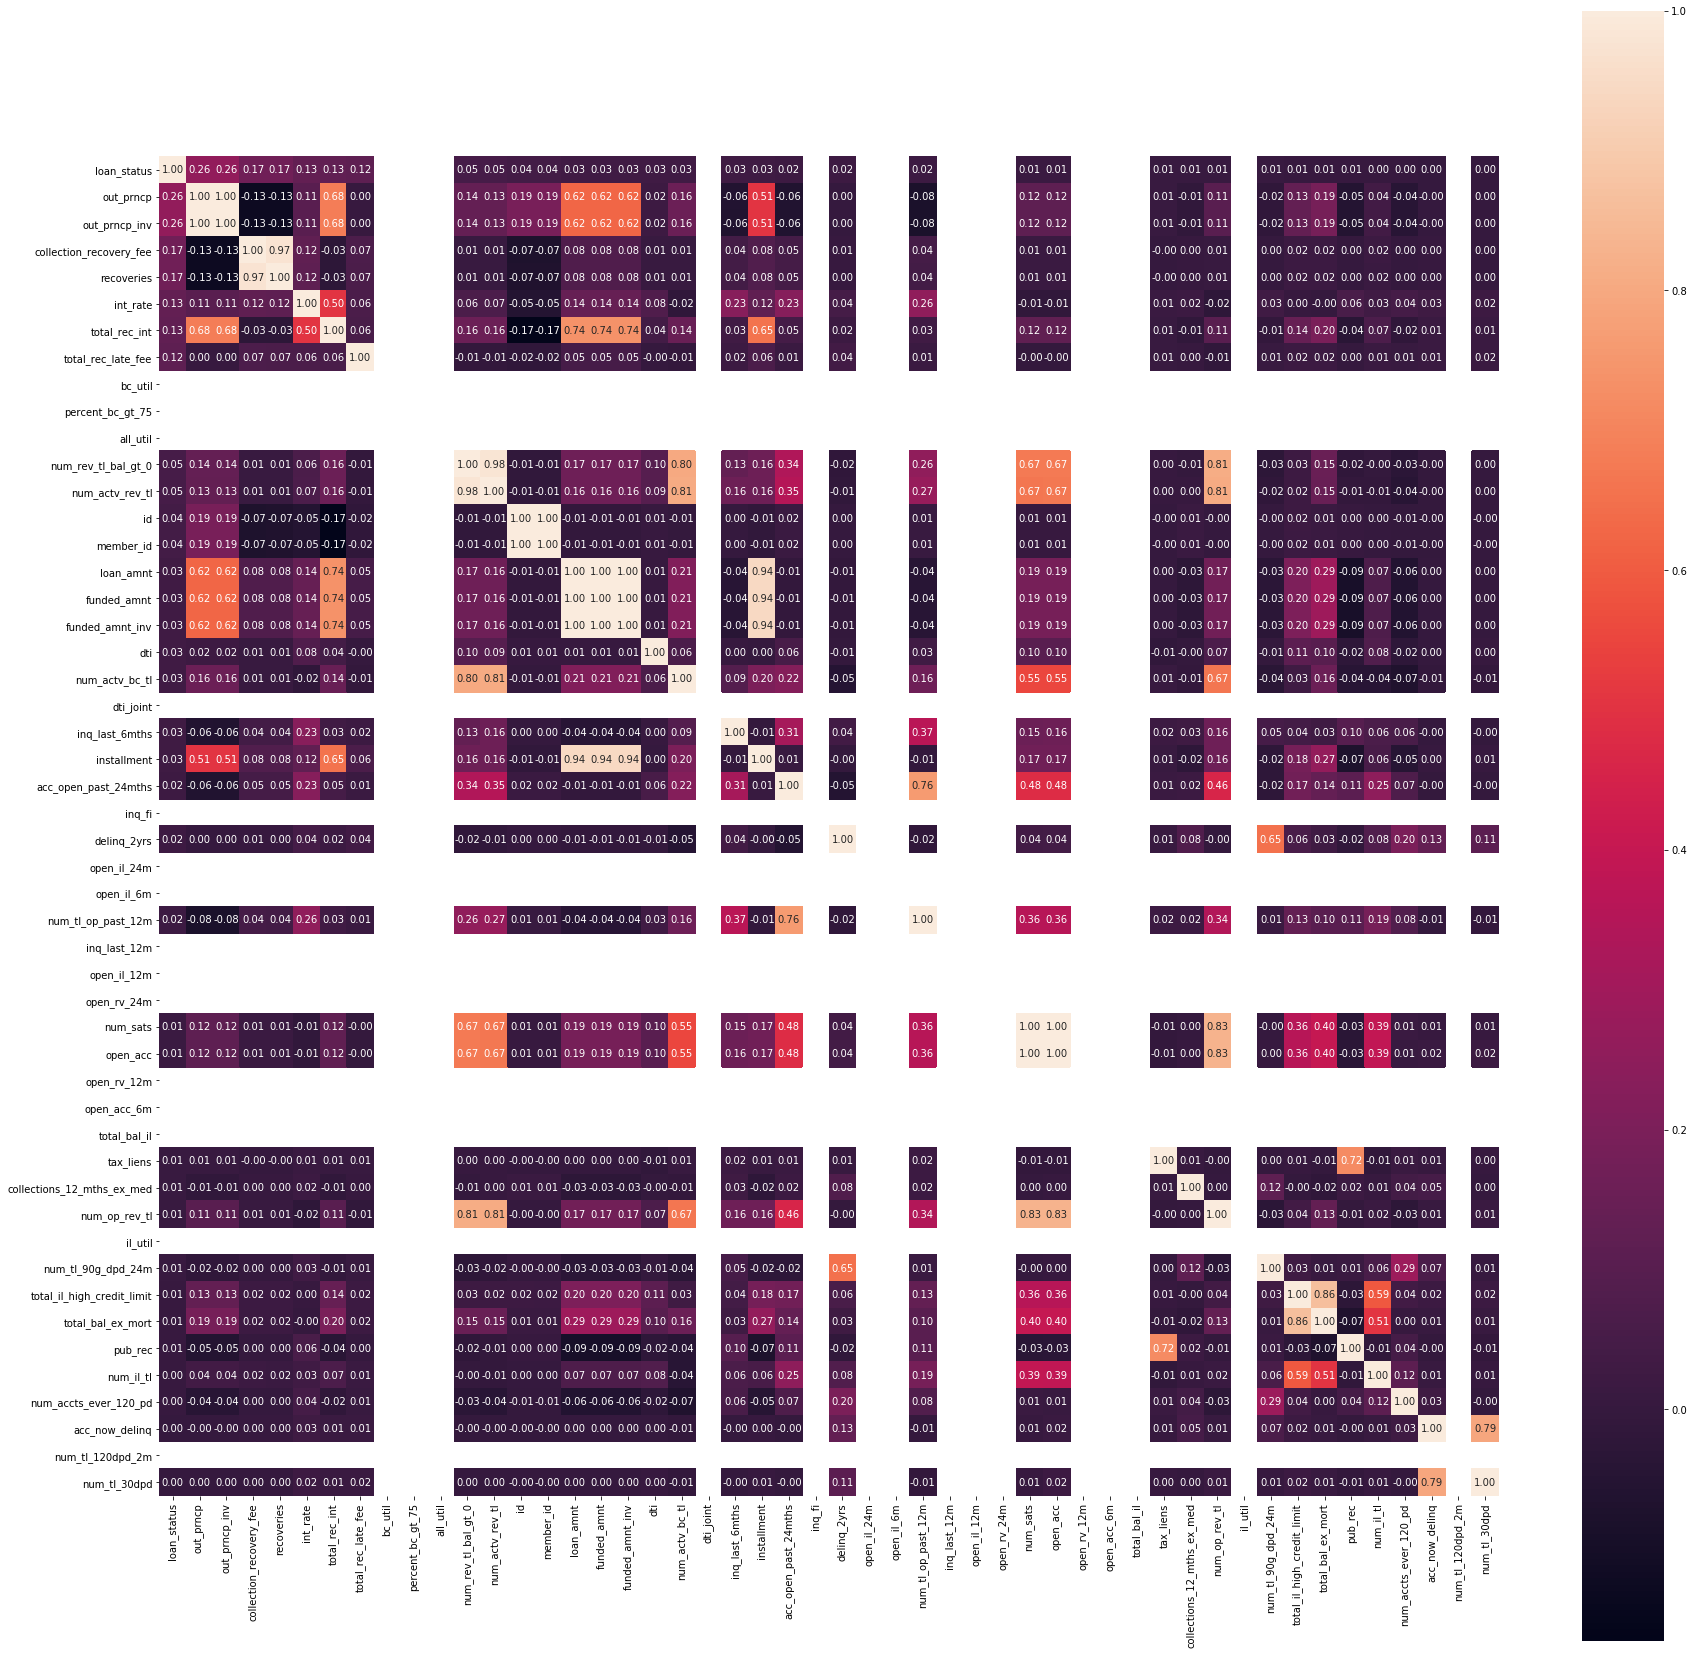

In [20]:
# Generate correlation matrix
cols = y2015.columns
corrmat = y2015.corr()

# Find 20 highest correlations to target variable
target = 'loan_status'
nr_cols = 50
print (corrmat.nlargest(nr_cols, target)[target])

cols = corrmat.nlargest(nr_cols, target)[target].index
cm = np.corrcoef(y2015[cols].values.T)

plt.figure(figsize=(30,30))
# Create and display heatmap
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [21]:
y2015 = y2015.drop(labels=['out_prncp_inv','recoveries','total_rec_int','bc_util','percent_bc_gt_75','all_util','num_rev_tl_bal_gt_0','id',
                           'member_id','funded_amnt','funded_amnt_inv','num_actv_bc_tl','dti_joint','inq_last_6mths','acc_open_past_24mths',
                           'inq_fi','open_il_24m','open_il_6m','num_tl_op_past_12m','inq_last_12m','open_il_12m','open_rv_24m','open_rv_12m',
                           'open_acc_6m','total_bal_il','num_op_rev_tl','il_util','num_tl_90g_dpd_24m','total_bal_ex_mort','num_il_tl','num_tl_120dpd_2m','num_tl_30dpd'], axis=1)

loan_status                       1.000
out_prncp                         0.261
collection_recovery_fee           0.169
int_rate                          0.133
total_rec_late_fee                0.118
num_actv_rev_tl                   0.050
loan_amnt                         0.034
dti                               0.032
installment                       0.028
delinq_2yrs                       0.021
num_sats                          0.015
open_acc                          0.015
tax_liens                         0.011
collections_12_mths_ex_med        0.011
total_il_high_credit_limit        0.007
pub_rec                           0.006
num_accts_ever_120_pd             0.004
acc_now_delinq                    0.002
chargeoff_within_12_mths          0.000
tot_coll_amt                     -0.001
delinq_amnt                      -0.001
num_bc_sats                      -0.002
revol_bal                        -0.004
mths_since_last_record           -0.004
pub_rec_bankruptcies             -0.006


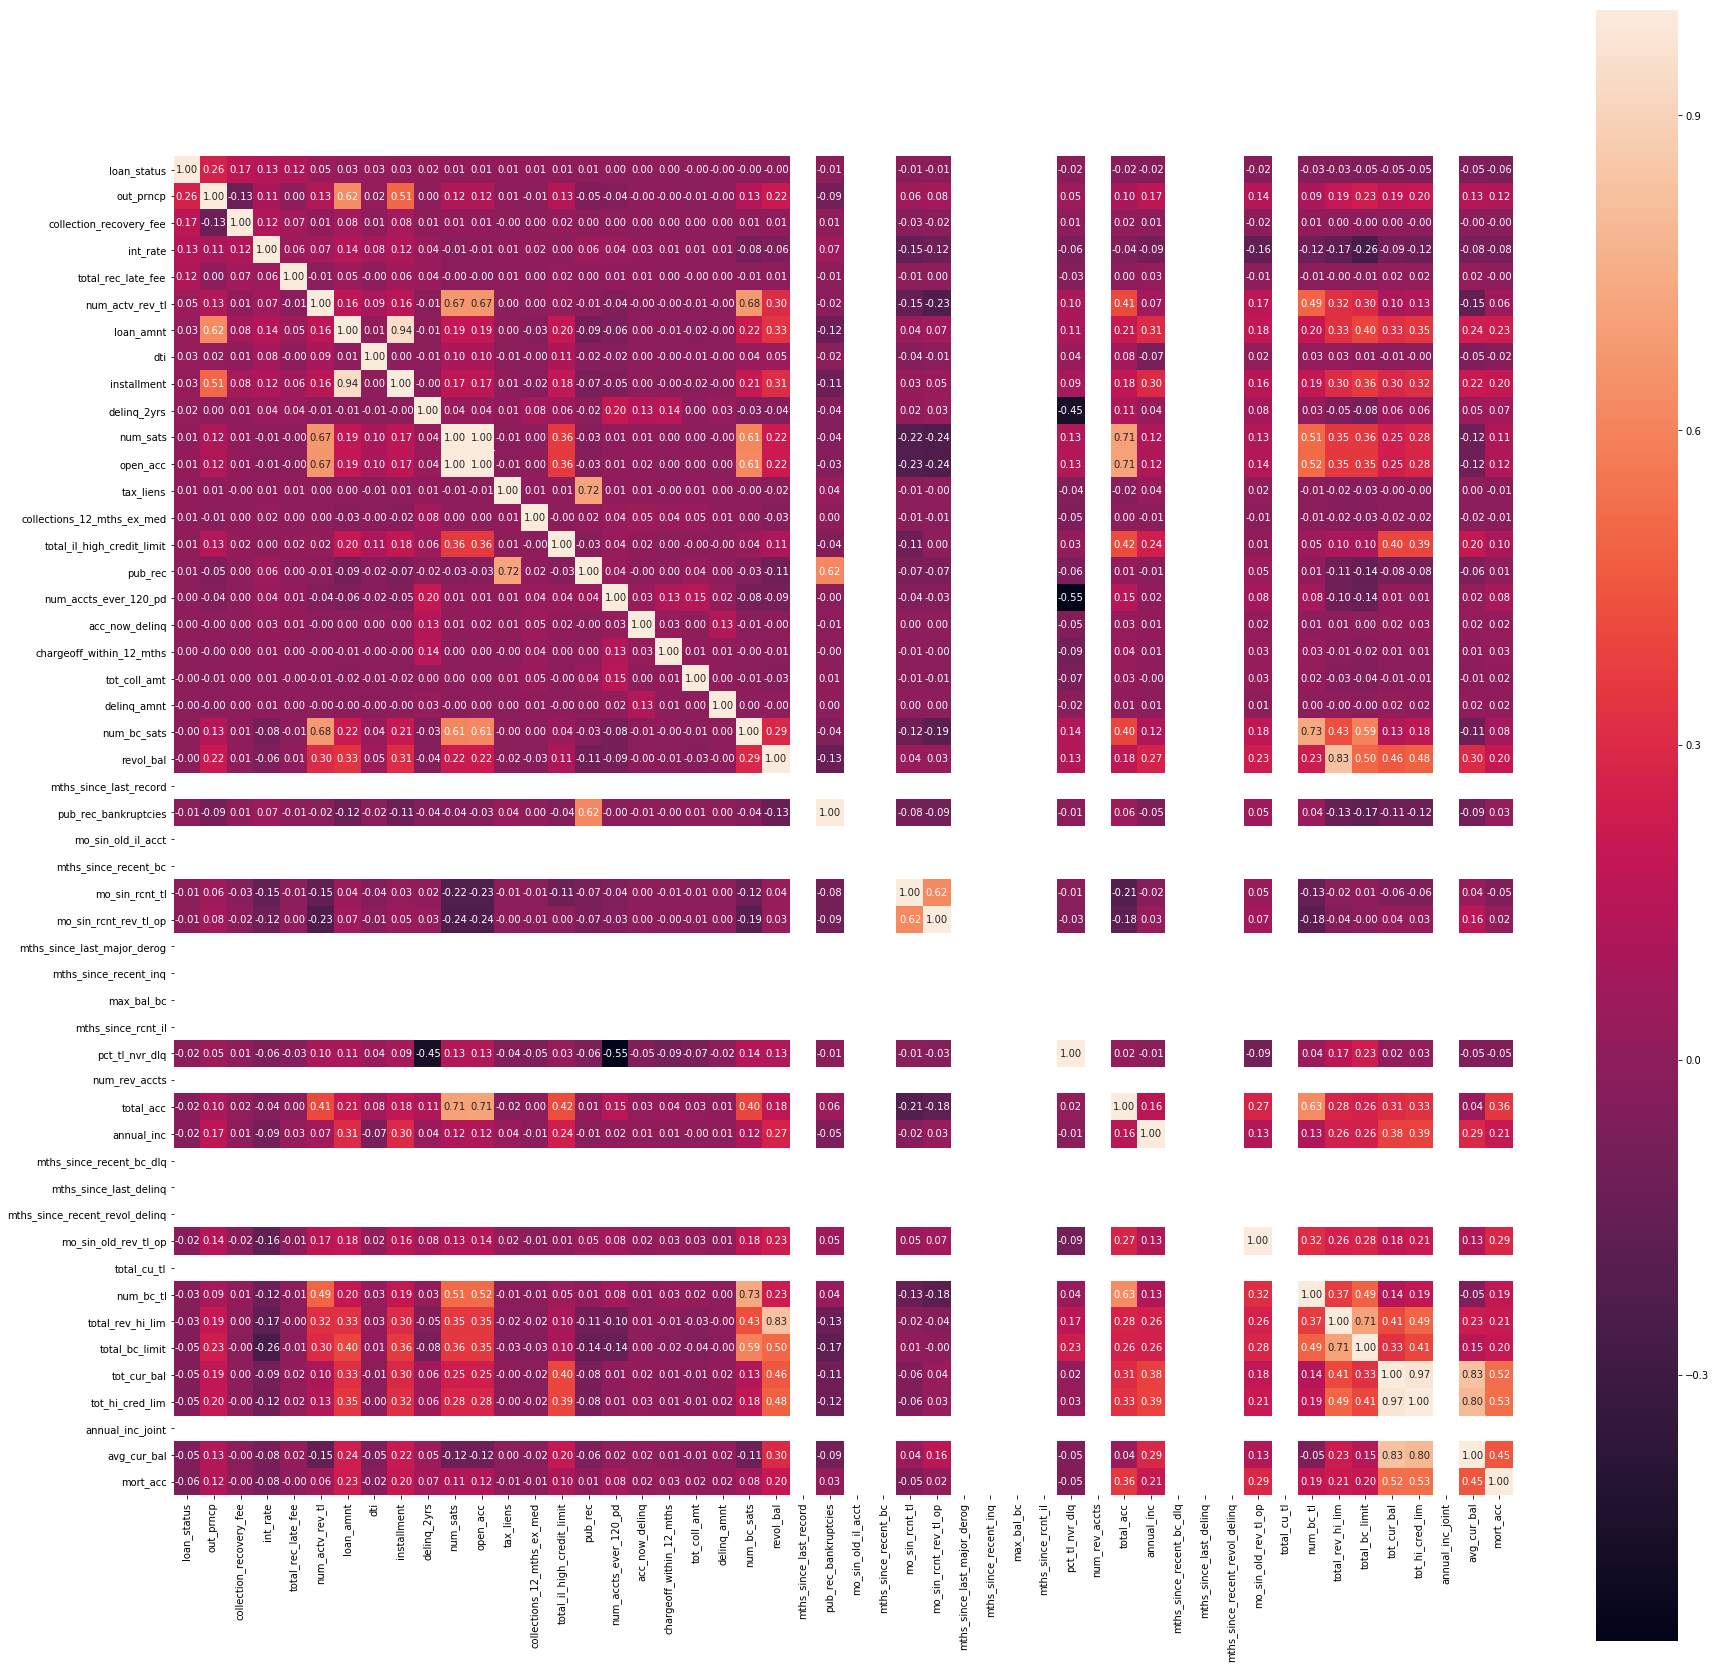

In [22]:
# Generate correlation matrix
cols = y2015.columns
corrmat = y2015.corr()

# Find 20 highest correlations to target variable
target = 'loan_status'
nr_cols = 50
print (corrmat.nlargest(nr_cols, target)[target])

cols = corrmat.nlargest(nr_cols, target)[target].index
cm = np.corrcoef(y2015[cols].values.T)

plt.figure(figsize=(30,30))
# Create and display heatmap
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [24]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.9801952 , 0.98024269, 0.98152502, 0.98138254, 0.97492282,
       0.9768701 , 0.97090883, 0.98002802, 0.97943335, 0.97969411])

In [25]:
y2015 = y2015.drop(labels=['acc_now_delinq','chargeoff_within_12_mths','num_bc_sats','revol_bal','mths_since_last_record',
                           'pub_rec_bankruptcies','mo_sin_old_il_acct','mths_since_recent_bc','mo_sin_rcnt_tl','mo_sin_rcnt_rev_tl_op',
                           'mths_since_last_major_derog','mths_since_recent_inq','max_bal_bc','mths_since_rcnt_il','num_rev_accts',
                           'mths_since_recent_bc_dlq','mths_since_last_delinq','mths_since_recent_revol_delinq','total_cu_tl','num_bc_tl',
                           'total_rev_hi_lim','total_bc_limit','tot_hi_cred_lim','annual_inc_joint','mort_acc'], axis=1)

In [26]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.9797915 , 0.97998148, 0.98109758, 0.98169124, 0.97226312,
       0.97216813, 0.96342825, 0.98071671, 0.97891087, 0.98045409])

In [27]:
y2015.shape

(421095, 46)

In [30]:
y2015.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'purpose', 'title', 'dti', 'delinq_2yrs',
       'open_acc', 'pub_rec', 'total_acc', 'initial_list_status', 'out_prncp',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_late_fee', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal',
       'avg_cur_bal', 'bc_open_to_buy', 'delinq_amnt', 'mo_sin_old_rev_tl_op',
       'num_accts_ever_120_pd', 'num_actv_rev_tl', 'num_sats',
       'pct_tl_nvr_dlq', 'tax_liens', 'total_il_high_credit_limit'],
      dtype='object')

In [32]:
# run model with reduced features and no payment amounts or ourstanding principal
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop(['loan_status','installment', 'out_prncp'],  1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.97915034, 0.97874665, 0.97917409, 0.98043267, 0.96513892,
       0.97625267, 0.96689544, 0.97819943, 0.97290237, 0.97784164])

In [33]:
# Niiiiiicee